In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning, module='sklearn',  lineno=196)

from sklearn import metrics
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from matplotlib.ticker import FixedLocator, FixedFormatter

import pyrolite.comp

from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

random_state = 2021

In [2]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

In [3]:
def evaluation(estimator, df, labels, init=None, kmeans=None, af=None):

    #df中是否包含TRUE VALUE这一列？
    estimator.fit(df)
    labels_pred = estimator.labels_ #这里是基于什么进行预测的？
    print(20 * '*', init, 20 * '*')
    if kmeans:
        print("Mean Inertia Score: ", estimator.inertia_)
    elif af:
        cluster_centers_indices = estimator.cluster_centers_indices_
        print("The estimated number of clusters: ", len(cluster_centers_indices))
    print("Homogeneity Score: ", metrics.homogeneity_score(labels, labels_pred))
    print("Completeness Score: ", metrics.completeness_score(labels, labels_pred))
    print("V Measure Score: ", metrics.v_measure_score(labels, labels_pred))
    print("Adjusted Rand Score: ", metrics.adjusted_rand_score(labels, labels_pred))
    print("Adjusted Mutual Info Score: ", metrics.adjusted_mutual_info_score(labels, labels_pred))
    print("Calinski Harabasz Score: ", metrics.calinski_harabasz_score(df, labels_pred))
    print("Silhouette Score: ", metrics.silhouette_score(df, labels_pred))

In [4]:
def plot_scores(init, max_k, df):
   
    i = []
    inertia_scores = []
    silhouette_scores = []
    calinski_harabaz_scores = []
    
    for k in range(2, max_k):
        kmeans_model = KMeans(n_clusters=k, random_state=random_state, init=init, n_init=10)
        pred = kmeans_model.fit_predict(df)
        i.append(k)
        inertia_scores.append(kmeans_model.inertia_)
        silhouette_scores.append(silhouette_score(df, pred))
        calinski_harabaz_scores.append(calinski_harabasz_score(df, pred))
        
    print(silhouette_scores)
    scores = [inertia_scores, silhouette_scores, calinski_harabaz_scores]
    
    positions = [131, 132, 133]
    ylabels = ['Inertia', 'Silhouette', 'Calinski Harabasz']
    
    fig = plt.figure(figsize = (12, 4), dpi = 300, tight_layout = True)
    for j in range(len(scores)):
        fig.add_subplot(positions[j])
        plt.plot(i, scores[j], 'bo-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('{} Scores'.format(ylabels[j]))
        plt.title('{} Scores with {} init'.format(ylabels[j], init), fontsize = 15)
        plt.subplots_adjust(wspace = 0.5)
#         plt.savefig('./{}_{}.png'.format(filename, max_k))

In [5]:
# results processed by pca
def pca_process(srp_orig):
    
    srp_orig = pd.concat([srp_orig], ignore_index = True)
    
    srp = srp_orig[elements].copy()
    labels_srp = srp_orig['Locations'].copy()
    
    srp = srp.replace(0, 0.0001)
    clr_srp = srp.pyrocomp.CLR()
    
    pca_srp = PCA()
    res_srp = pd.DataFrame(pca_srp.fit_transform(clr_srp), columns = cols)
    X_srp = res_srp.iloc[:, :3]
    
    return res_srp, X_srp, pca_srp


# dataset processed by kmeans
def km_process(srp_orig, n_clusters, n_init = 10):
    
    res_srp, X_srp, pca_srp = pca_process(srp_orig)
    
    km = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = n_init, random_state = 2021)
    km.fit(X_srp)
    srp_final = srp_orig.copy()
    srp_final['km_label'] = km.labels_
    srp_final = pd.concat([srp_final, res_srp], axis = 1)
    
    return srp_final

In [6]:
a = 200
def plot_scatter(df, x, y, hue, alpha, style, a, pca):
    
    plt.figure(figsize = (8, 6), dpi = 300, tight_layout = True)
    
    sns.scatterplot(data = df, x = x, y = y, hue = hue, alpha = alpha, palette = 'tab10',
                    style = style, size = style, sizes = (a, a))
    b = int(x[-1]) - 1
    c = int(y[-1]) - 1
    plt.xlabel('PC{} Variance = {:.2%}'.format(b+1, pca.explained_variance_ratio_[b]))
    plt.ylabel('PC{} Variance = {:.2%}'.format(c+1, pca.explained_variance_ratio_[c]))
    
    
    plt.legend()

In [7]:
df = pd.read_excel('Ophiolite.xlsx', sheet_name = 'Data_knn')

In [8]:
features_OP = ['Ref. ID', 'Publication Information', 'Locations', 'Period','Mineralogy', 'TRUE VALUE']

In [9]:
elements = [
            'SiO2(wt.%)', 
            'TiO2(wt.%)', 
            'Al2O3(wt.%)',
            'Cr2O3(wt.%)', 
            'FeOtot(wt.%)', 
            'MnO(wt.%)', 
            'NiO(wt.%)', 
            'MgO(wt.%)'
           ]

cols = ['PC'+str(i+1) for i in range(len(elements))]

In [10]:
def plot_Silhouette(df, mark_k, title):
    i = []
    silhouette_scores = []

    
    for k in range(2, mark_k):
        kmeans_model = KMeans(n_clusters=k, random_state=random_state, init='k-means++', n_init=10)
        pred = kmeans_model.fit_predict(df)
        i.append(k)
        silhouette_scores.append(silhouette_score(df, pred))
    

    fig = plt.figure(figsize = (4, 4), dpi = 300, tight_layout = True)
    plt.plot(i, silhouette_scores, 'bo-')
    plt.xlabel('Cluster Number')
    plt.ylabel('Silhouette Scores')
    plt.title(title, fontsize = 15)

## Kmeans clustering after pca processed

### High Temperature

In this case, the original dataset was firstly processed by pyrolite. This requires that the dataset cannot contain nan value.

In [11]:
H_Srp_orig = df[df['Mineralogy'] == 'H_Srp'].copy()
H_Srp_orig = pd.concat([H_Srp_orig], ignore_index = True)

In [12]:
res_H_Srp, X_H_Srp, pca_H = pca_process(H_Srp_orig)

[0.49854078675219254, 0.5518971727900425, 0.567257205965373, 0.45312607346263223, 0.47271183404717443, 0.48418088192614434, 0.4416471593730738, 0.40860171038518966, 0.4139174778820912, 0.35506246142686243, 0.395028888123417, 0.3554240415539603, 0.36005614190341567, 0.34964520679013456, 0.36010057380161326, 0.3345353885349451, 0.3520639455656821, 0.3236300968380367]


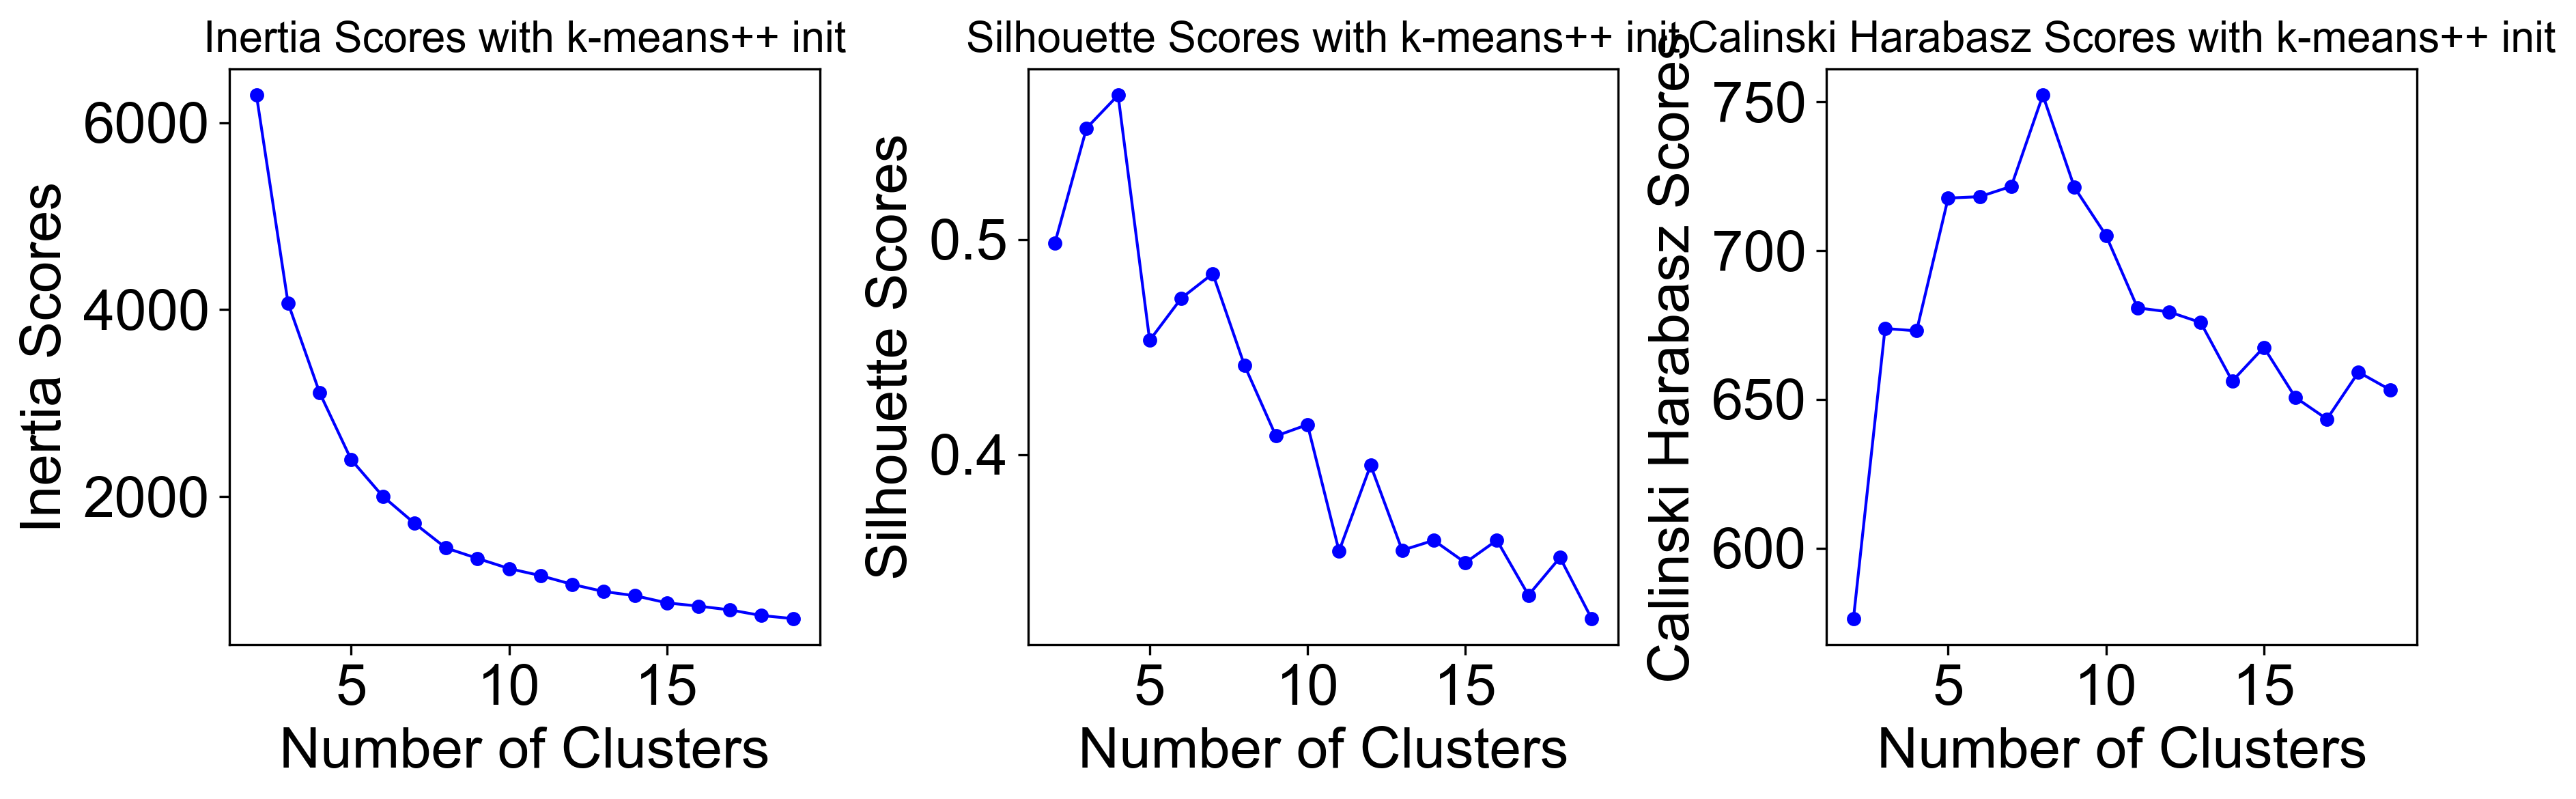

In [13]:
plot_scores('k-means++', 20, X_H_Srp)
plt.savefig('./H_Srp_comparison.png')

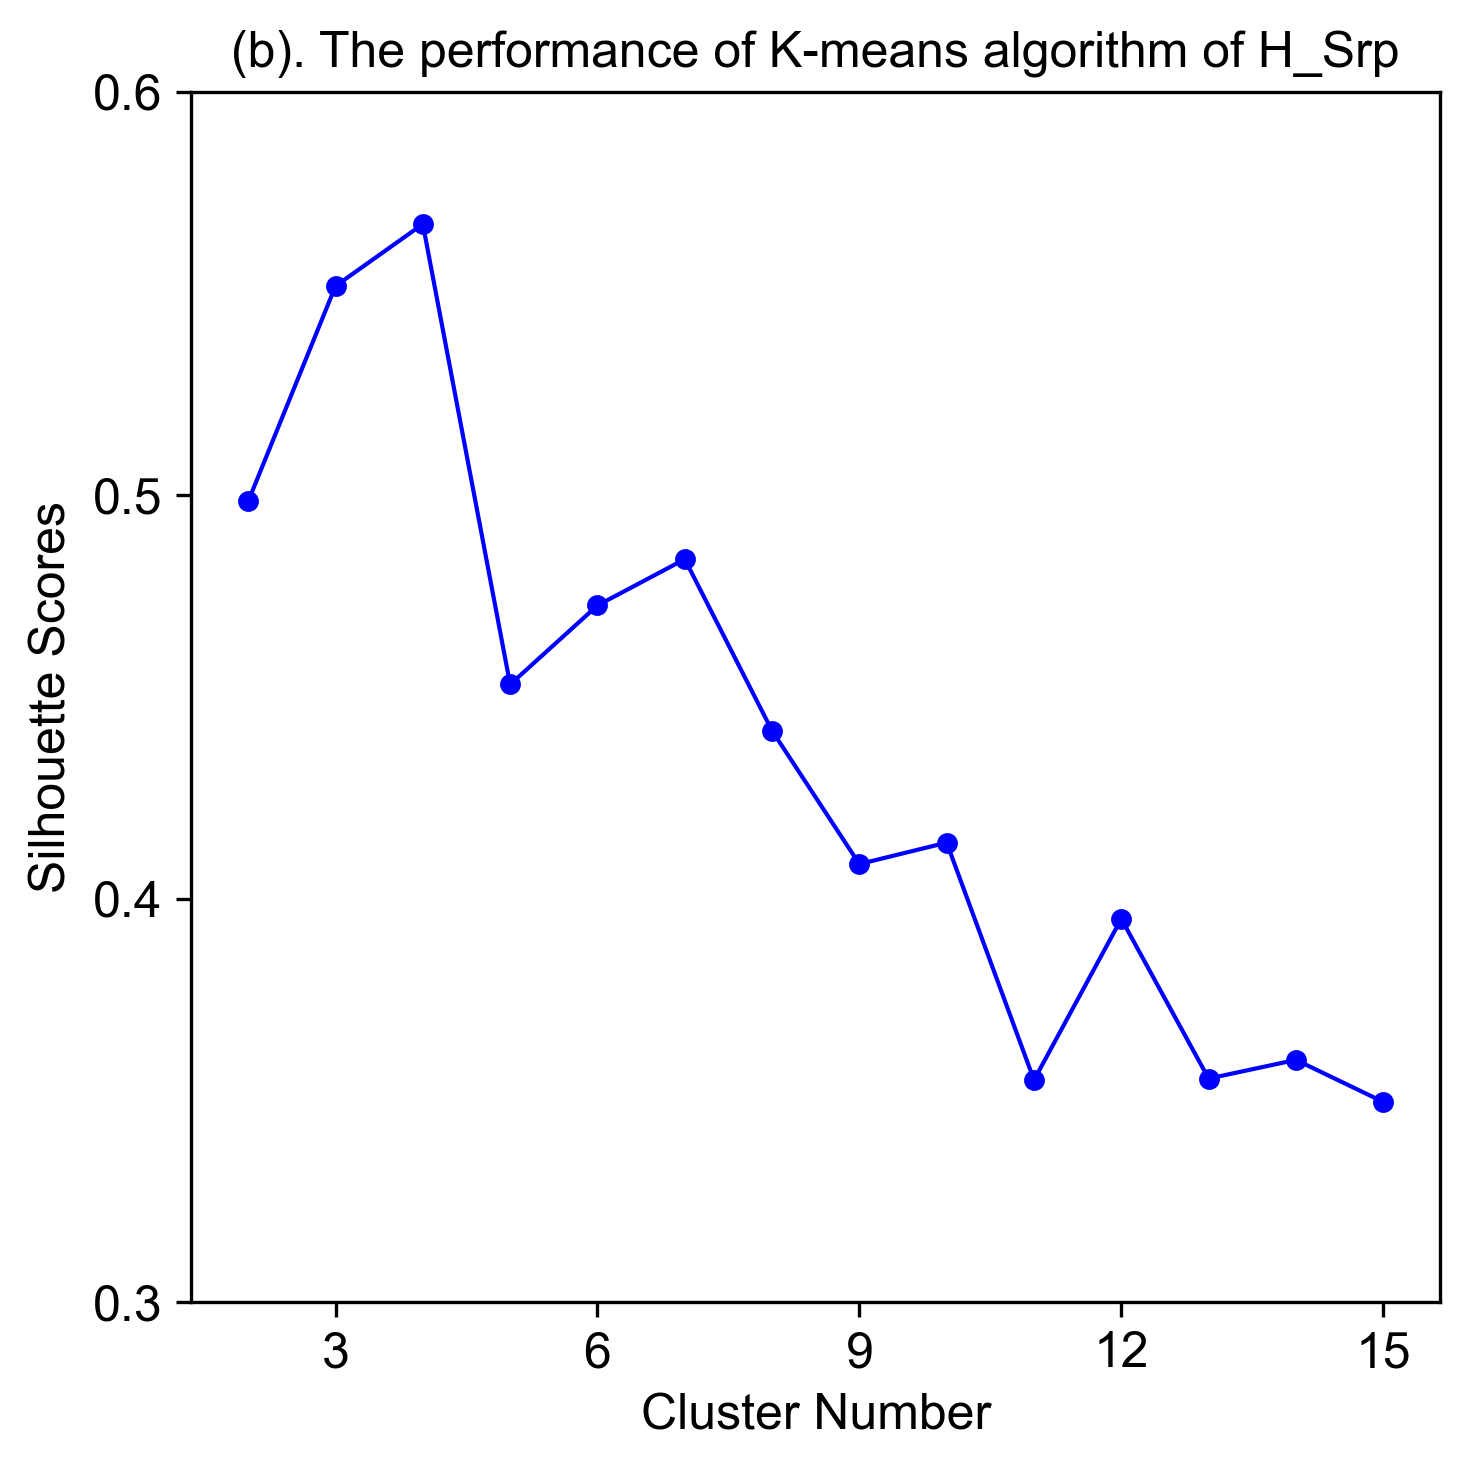

In [14]:
i = []
silhouette_scores = []

    
for k in range(2, 16):
    kmeans_model = KMeans(n_clusters=k, random_state=random_state, init='k-means++', n_init=10)
    pred = kmeans_model.fit_predict(X_H_Srp)
    i.append(k)
    silhouette_scores.append(silhouette_score(X_H_Srp, pred))
    

fig = plt.figure(figsize = (5, 5), dpi = 300, tight_layout = True)
plt.plot(i, silhouette_scores, 'bo-')
plt.xlabel('Cluster Number', fontsize = 12)
plt.xticks([3, 6, 9, 12, 15], fontsize = 12)
plt.ylim((0.3, 0.6))
plt.yticks([0.3, 0.4, 0.5, 0.6], fontsize = 12)
plt.ylabel('Silhouette Scores', fontsize = 12)
plt.title('(b). The performance of K-means algorithm of H_Srp', fontsize = 12)
plt.savefig('./H_Srp_Silhouette Scores.png')

In [15]:
H_Srp_final = km_process(H_Srp_orig, 4)

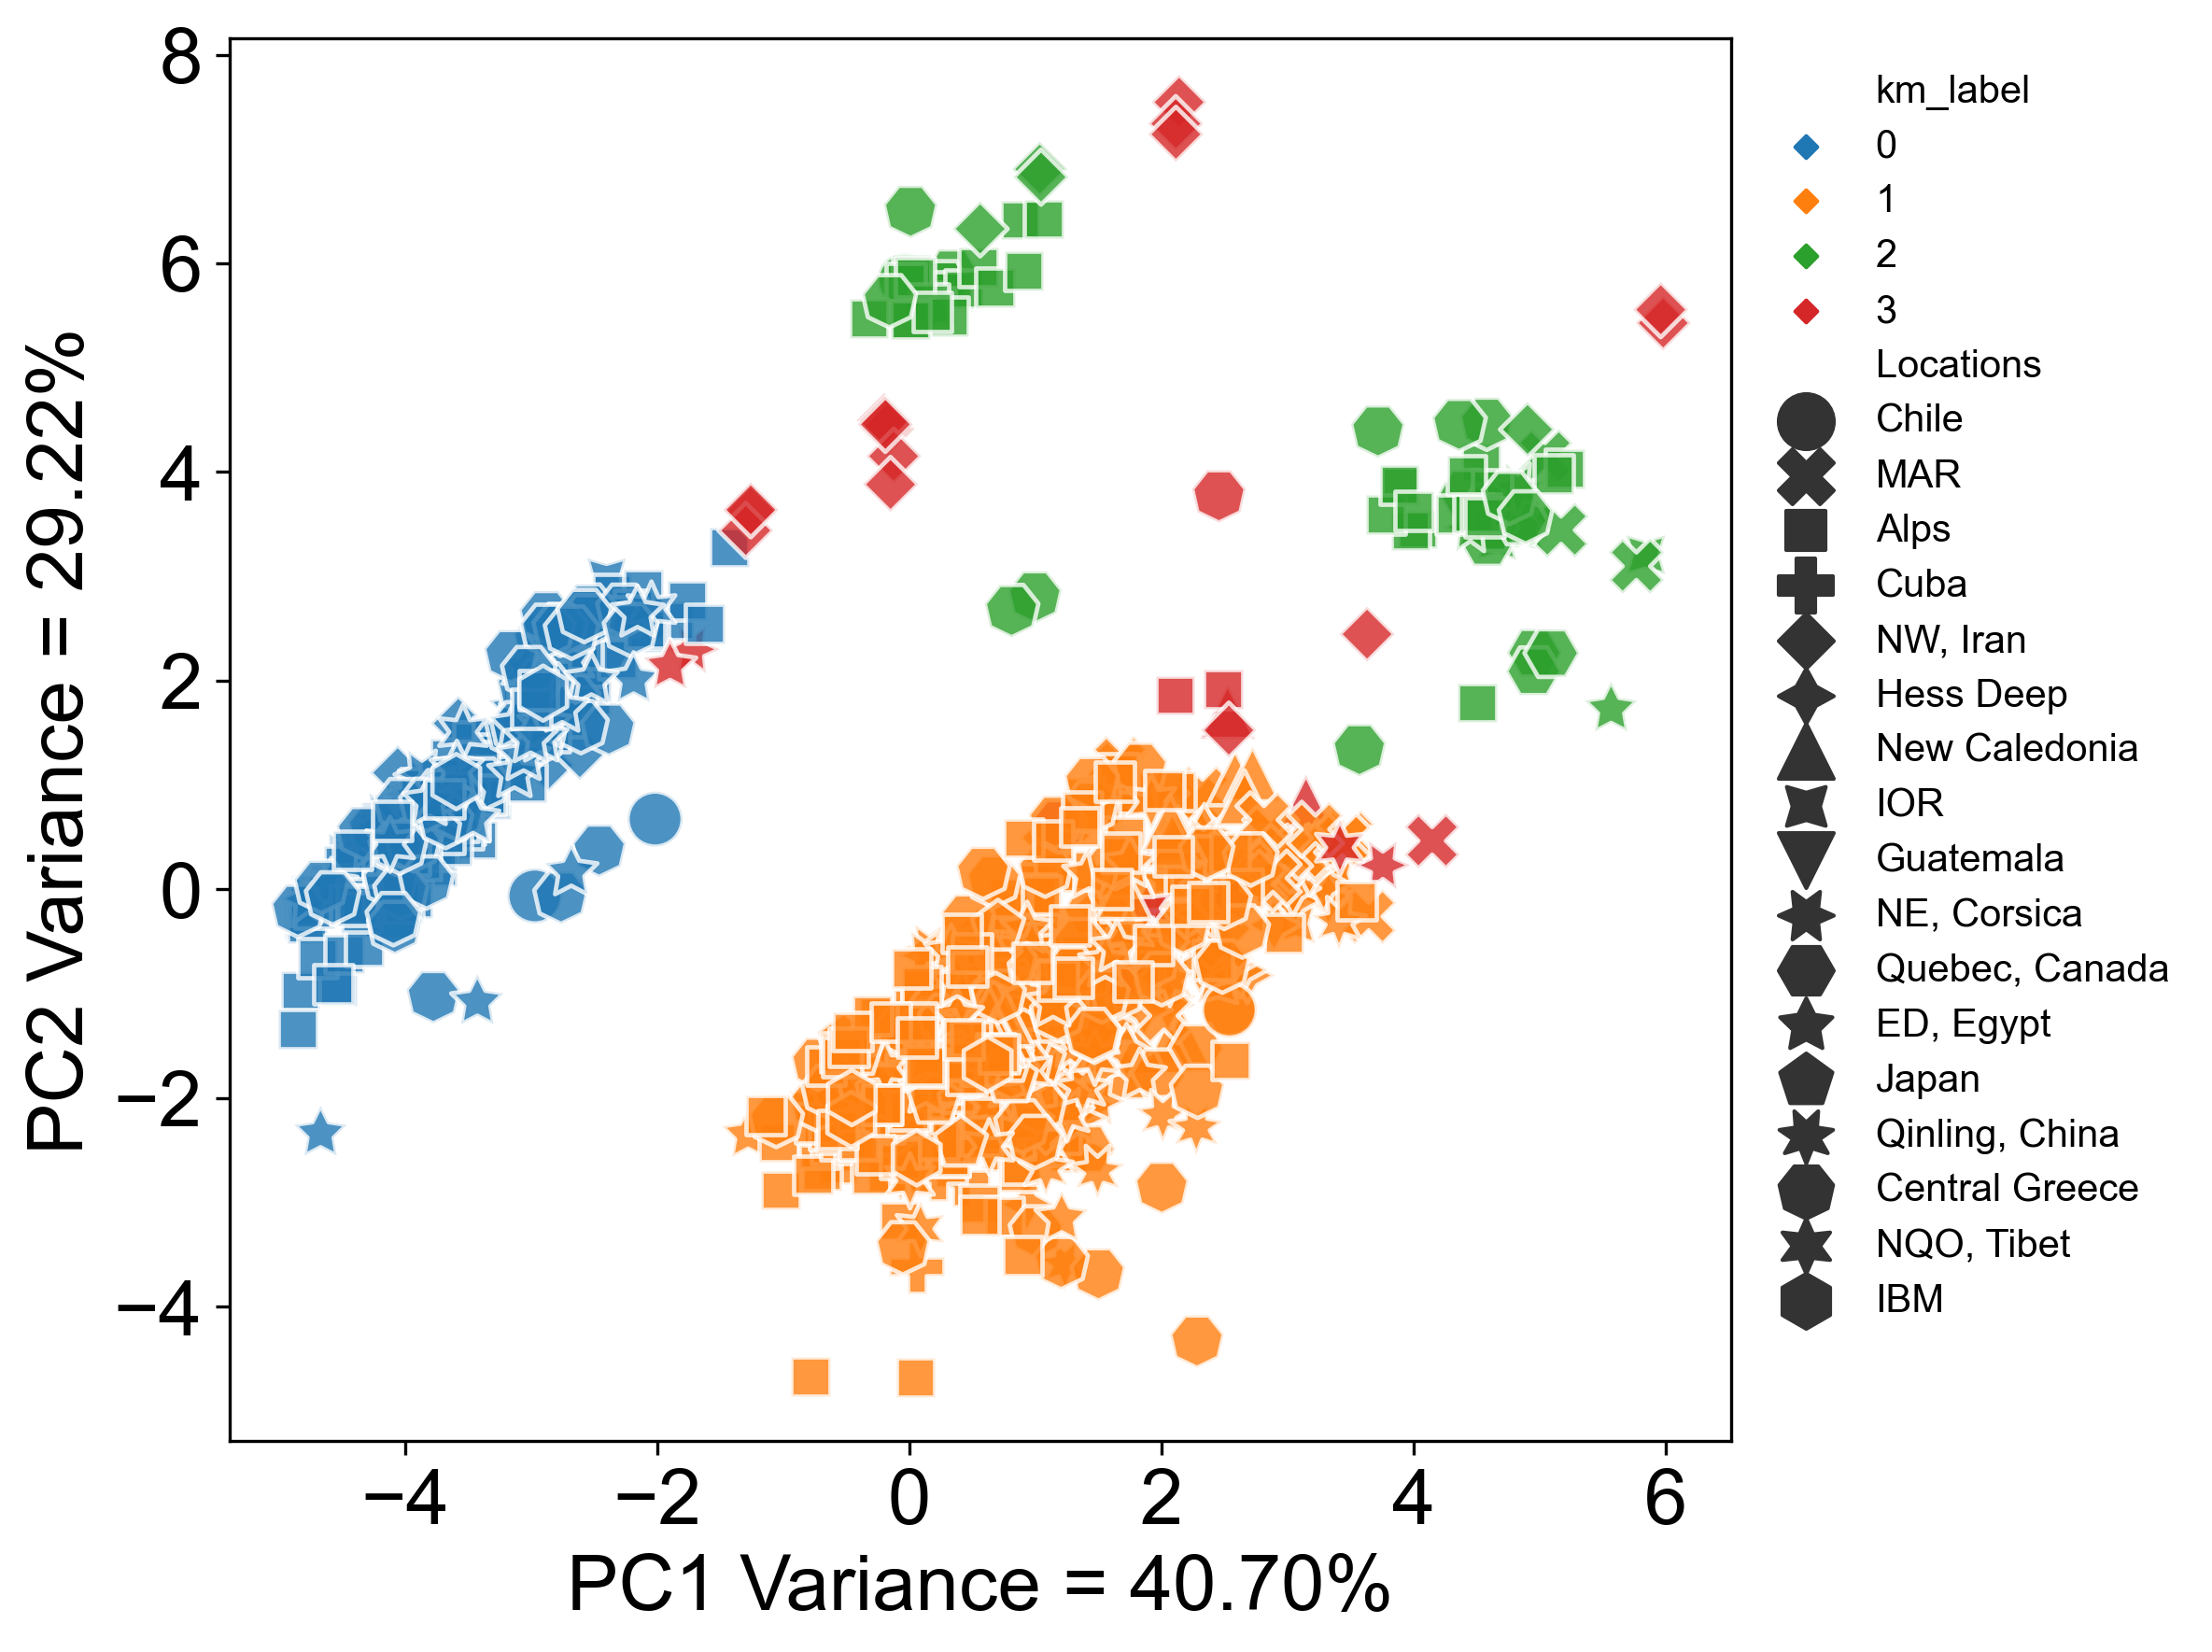

In [16]:
plot_scatter(H_Srp_final, 'PC1', 'PC2', 'km_label', 0.8, 'Locations', a, pca_H)
plt.savefig('./H_Srp_1.png')

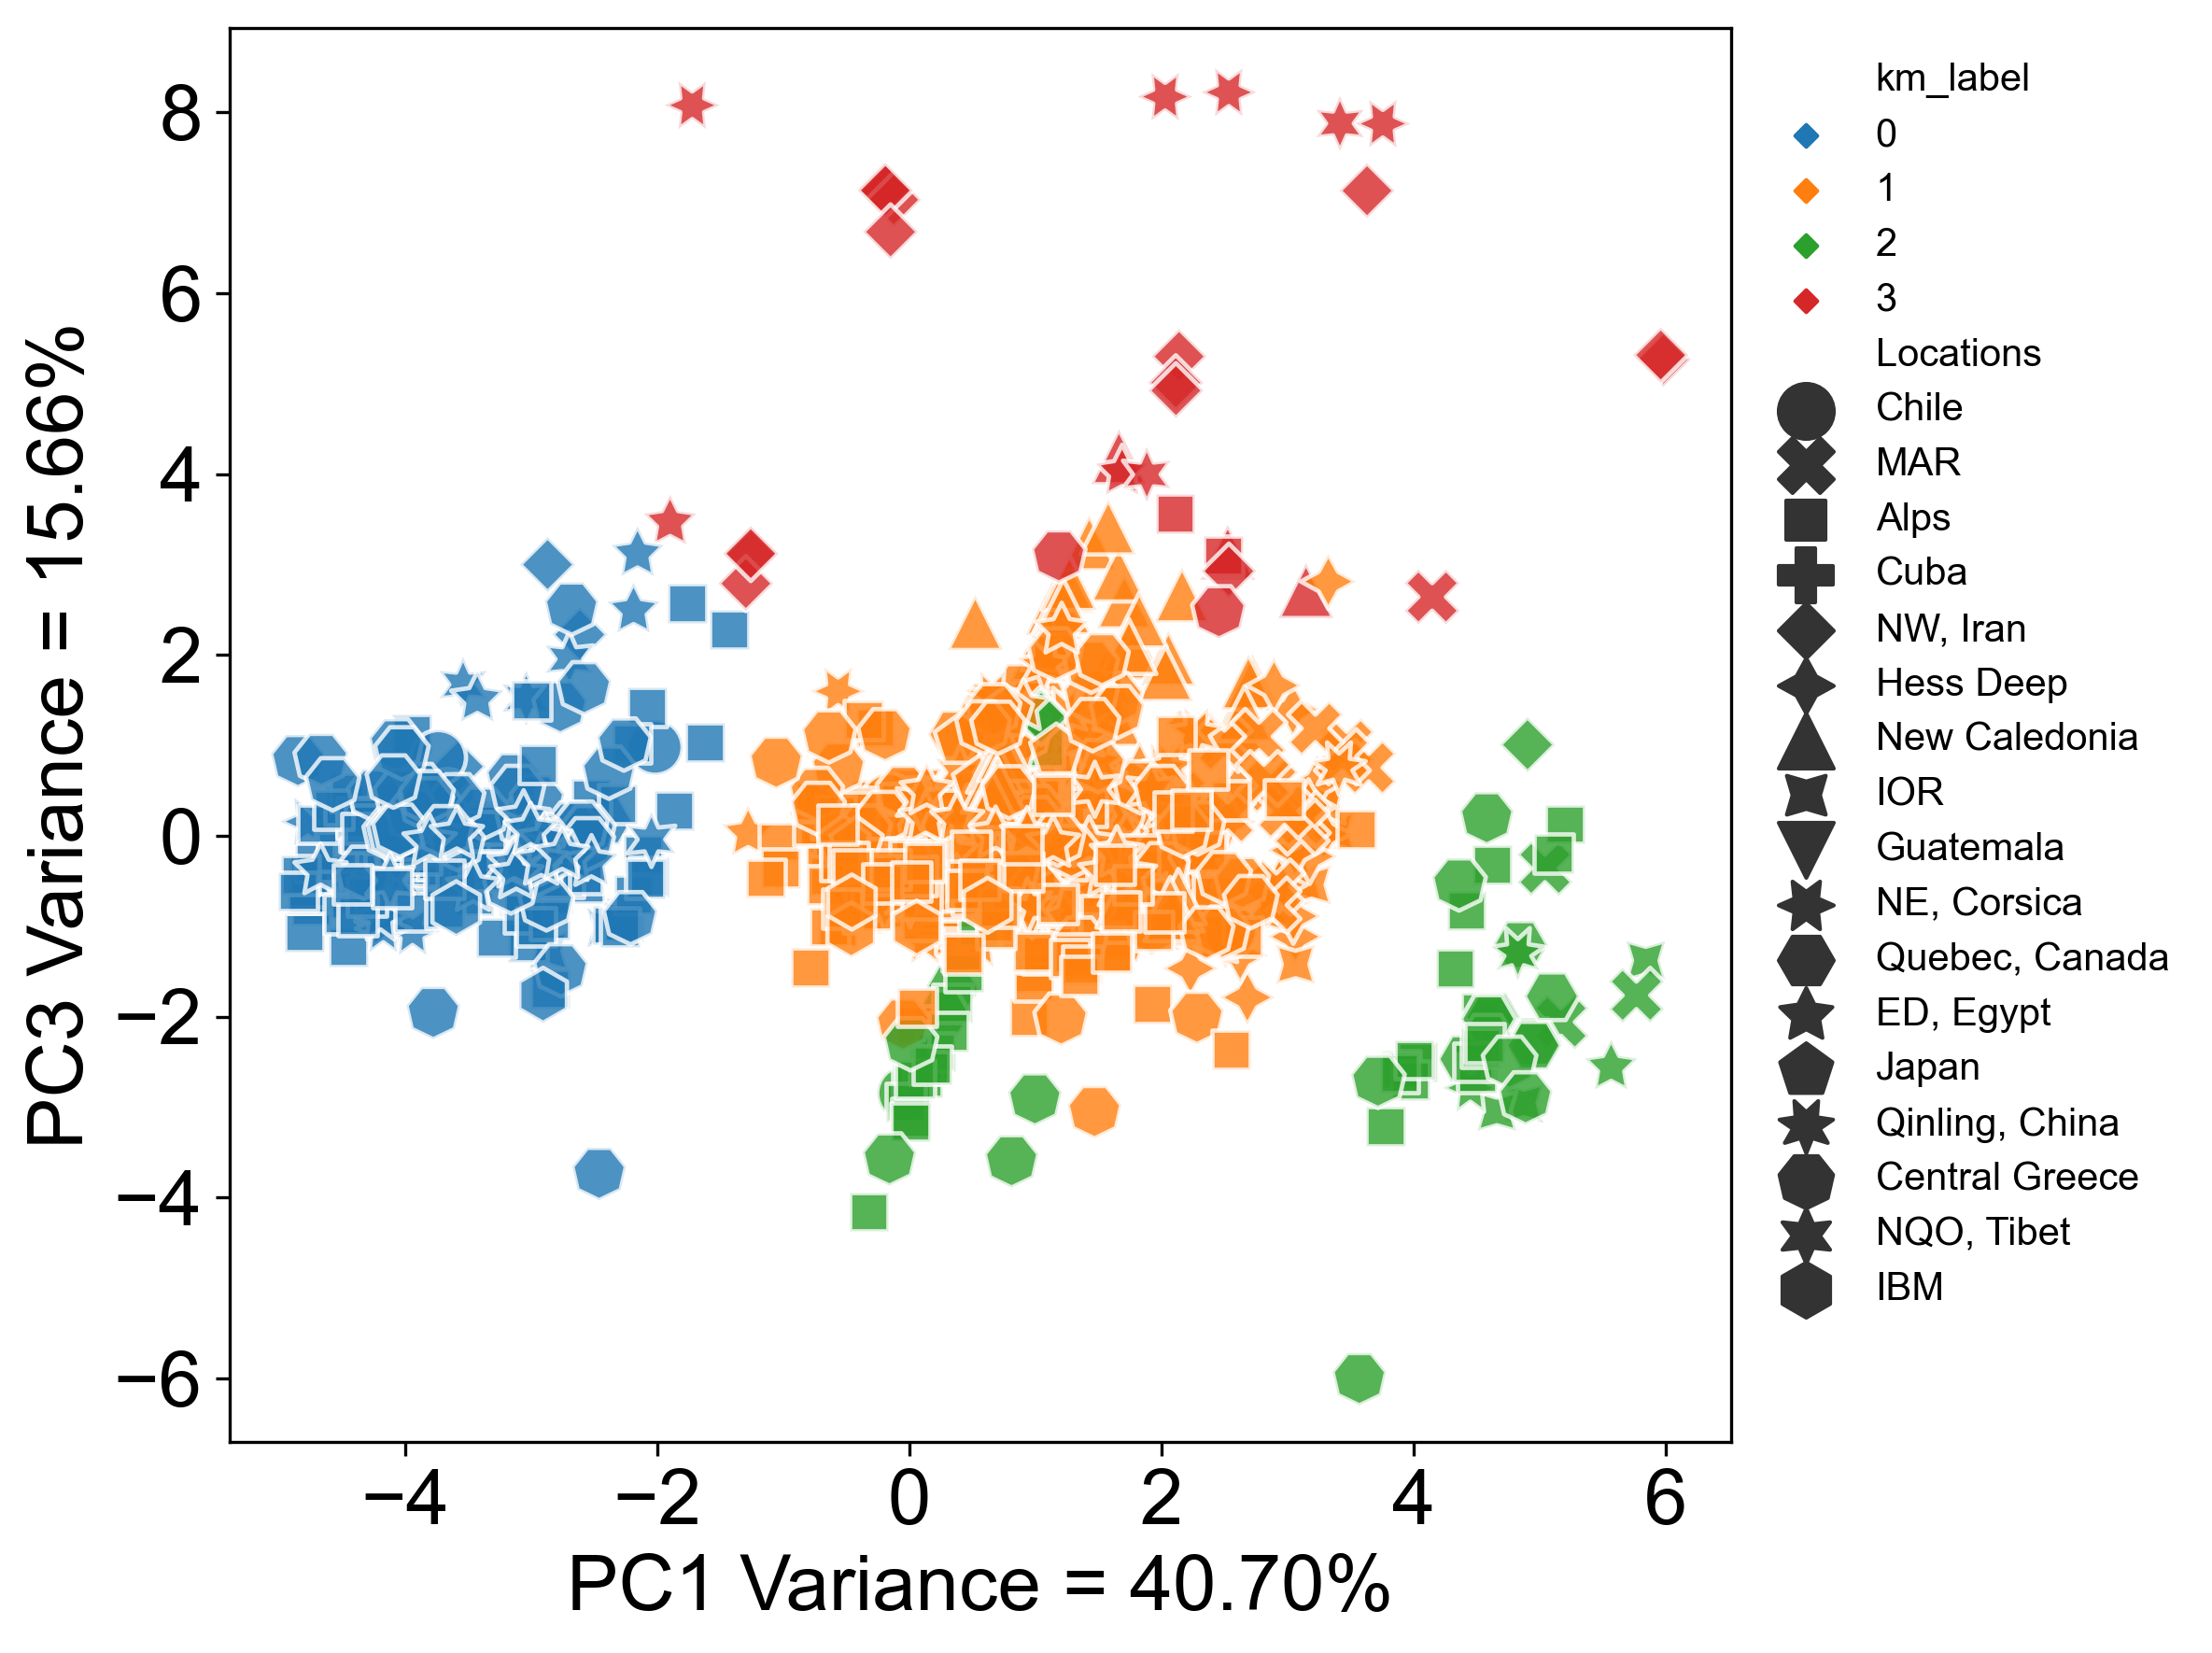

In [17]:
plot_scatter(H_Srp_final, 'PC1', 'PC3', 'km_label', 0.8, 'Locations', a, pca_H)
plt.savefig('./H_Srp_2.png')

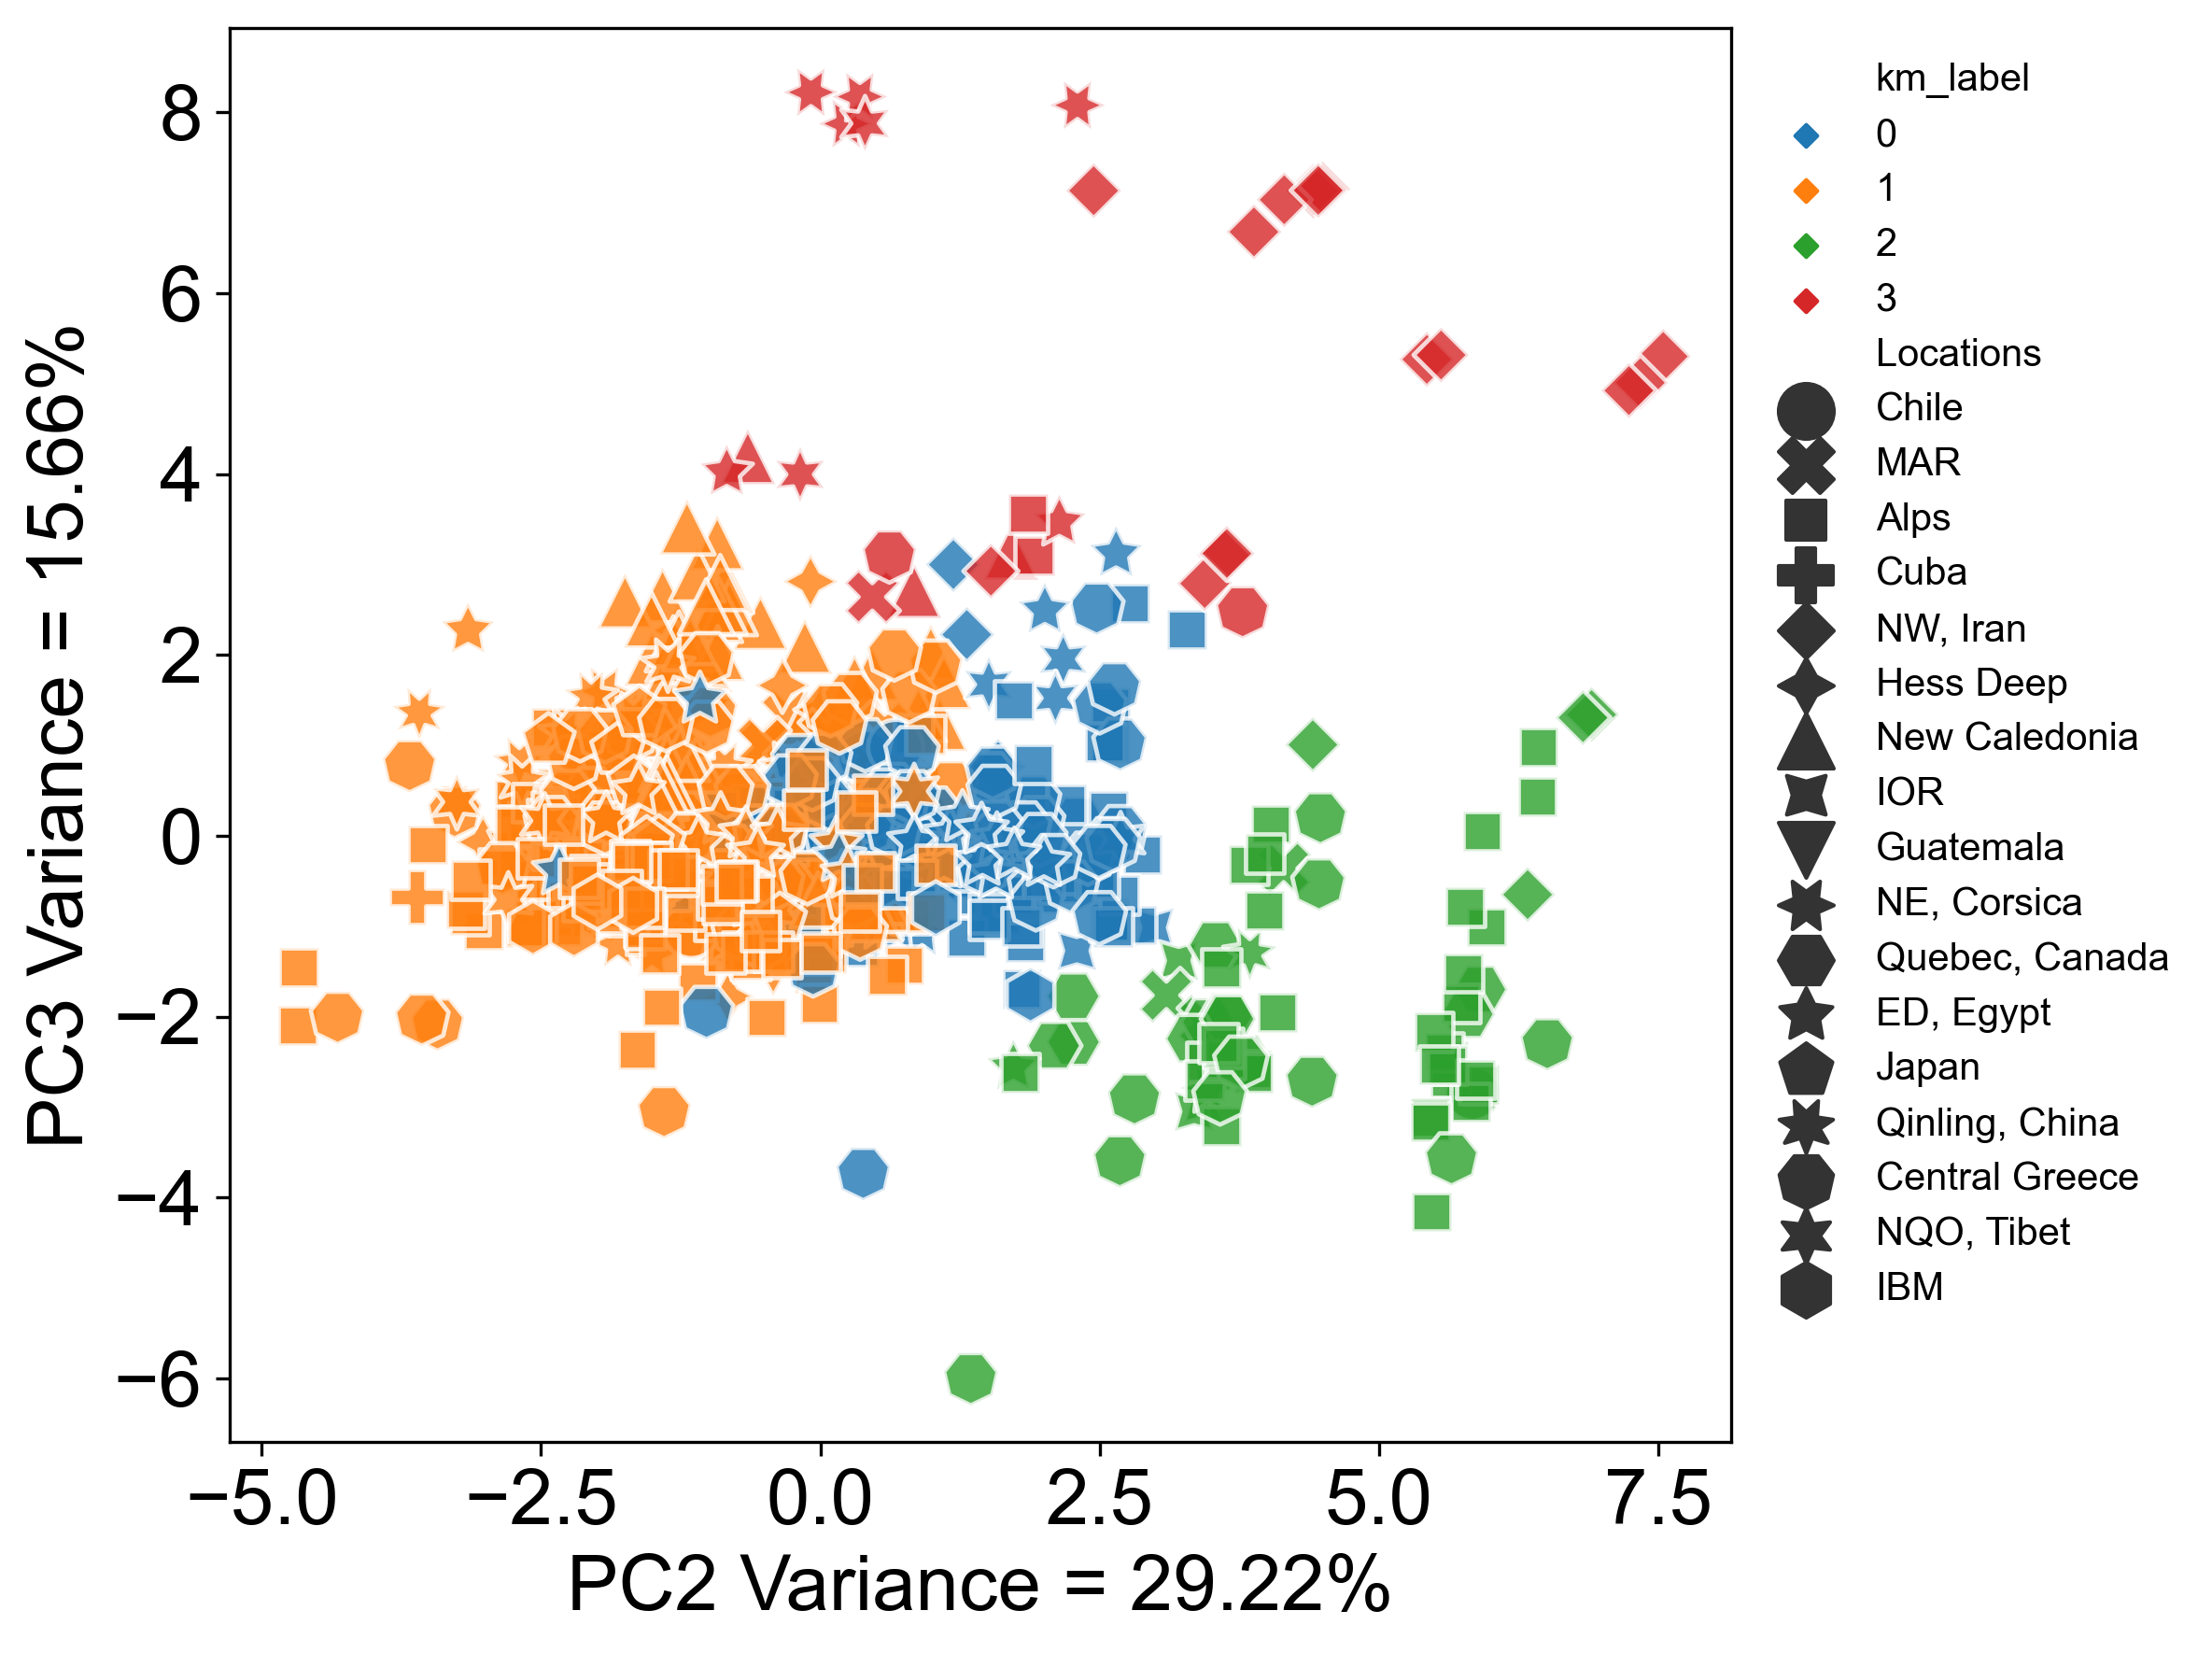

In [18]:
plot_scatter(H_Srp_final, 'PC2', 'PC3', 'km_label', 0.8, 'Locations', a, pca_H)
plt.savefig('./H_Srp_3.png')

### Low Temperature Serpentine 

In [19]:
L_Srp_orig = df[df['Mineralogy'] == 'L_Srp'].copy()
L_Srp_orig = pd.concat([L_Srp_orig], ignore_index = True)

In [20]:
res_L_Srp, X_L_Srp, pca_L = pca_process(L_Srp_orig)

[0.48324627200349823, 0.5148555902735056, 0.5396329288778942, 0.43042449184140597, 0.45585247776680626, 0.46224811199085986, 0.4511080454399114, 0.4450496003242115, 0.4473680980071488, 0.3978628193461315, 0.383752735468022, 0.3778643138510815, 0.3862627197089541, 0.38366145279851144, 0.3569376043222822, 0.351862929023279, 0.3628984872424706, 0.3655915167842784]


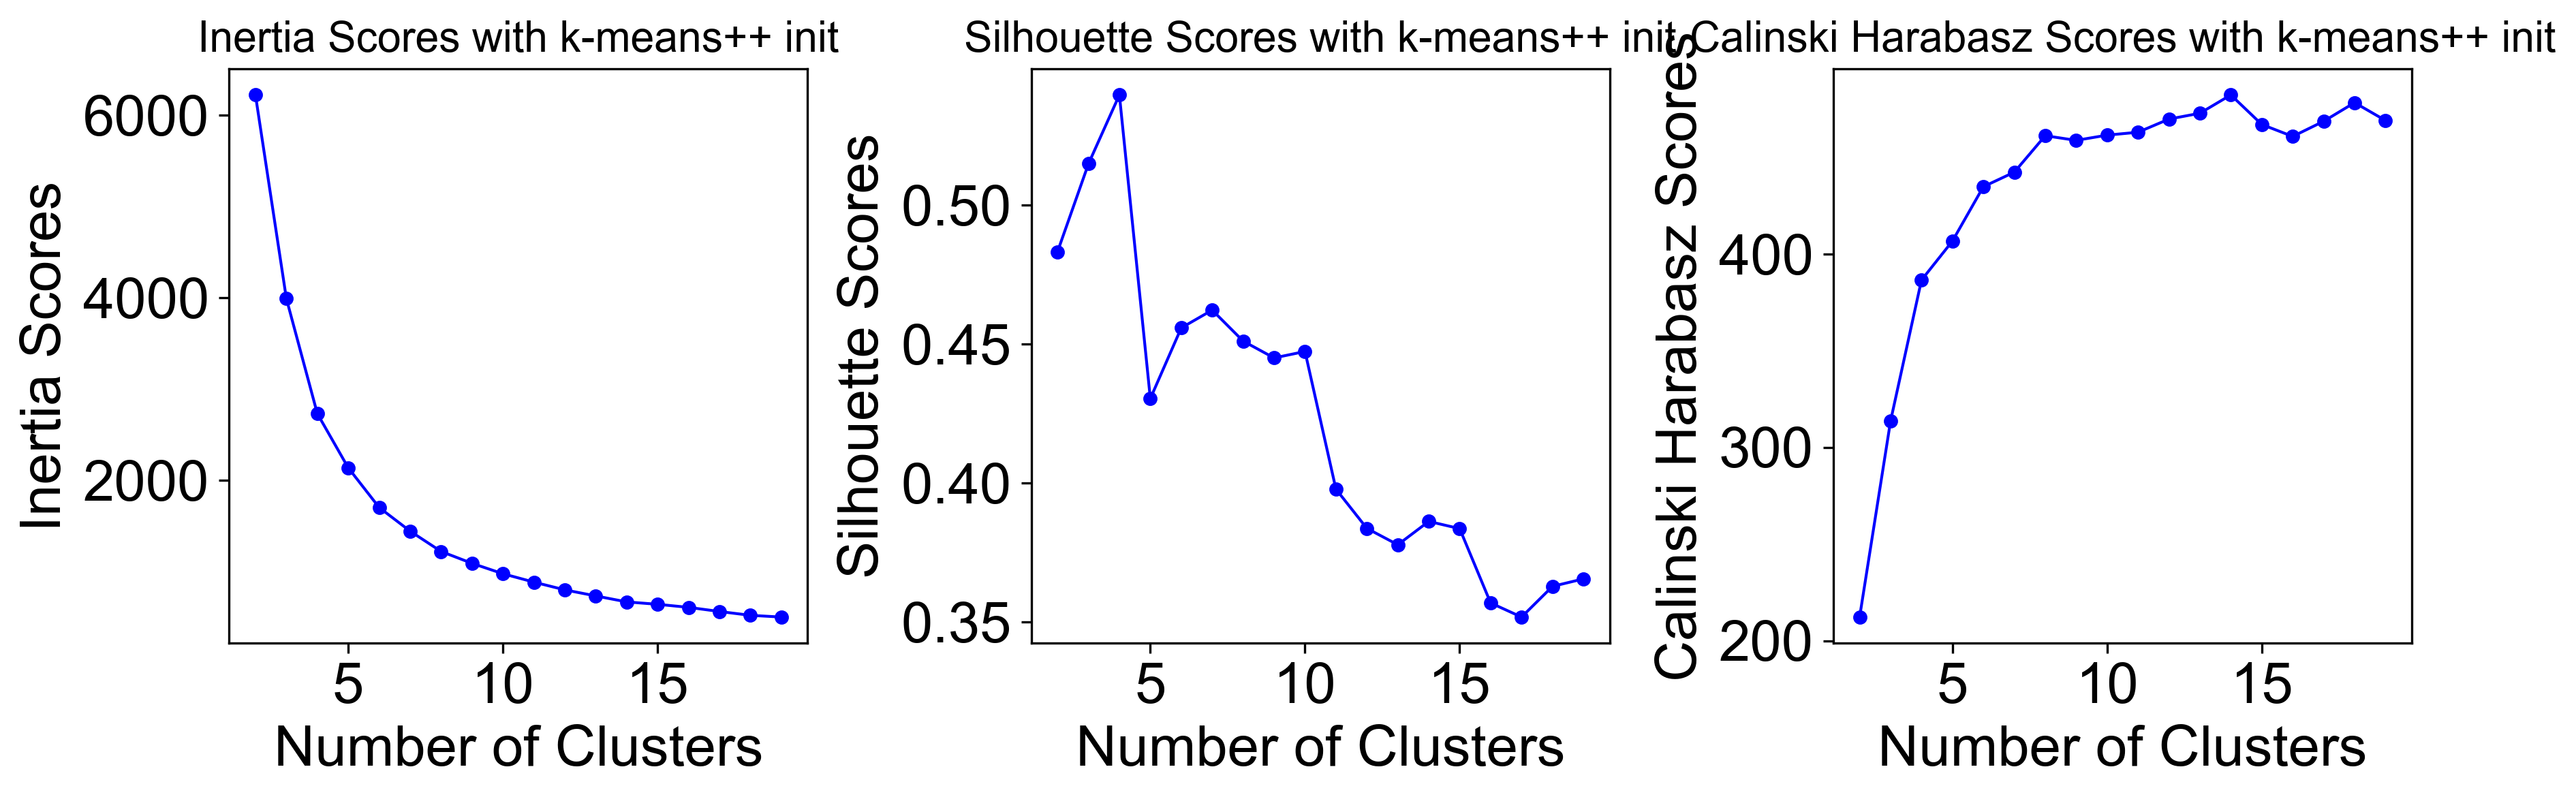

In [21]:
plot_scores('k-means++', 20, X_L_Srp)
plt.savefig('./L_Srp_comparison.png')

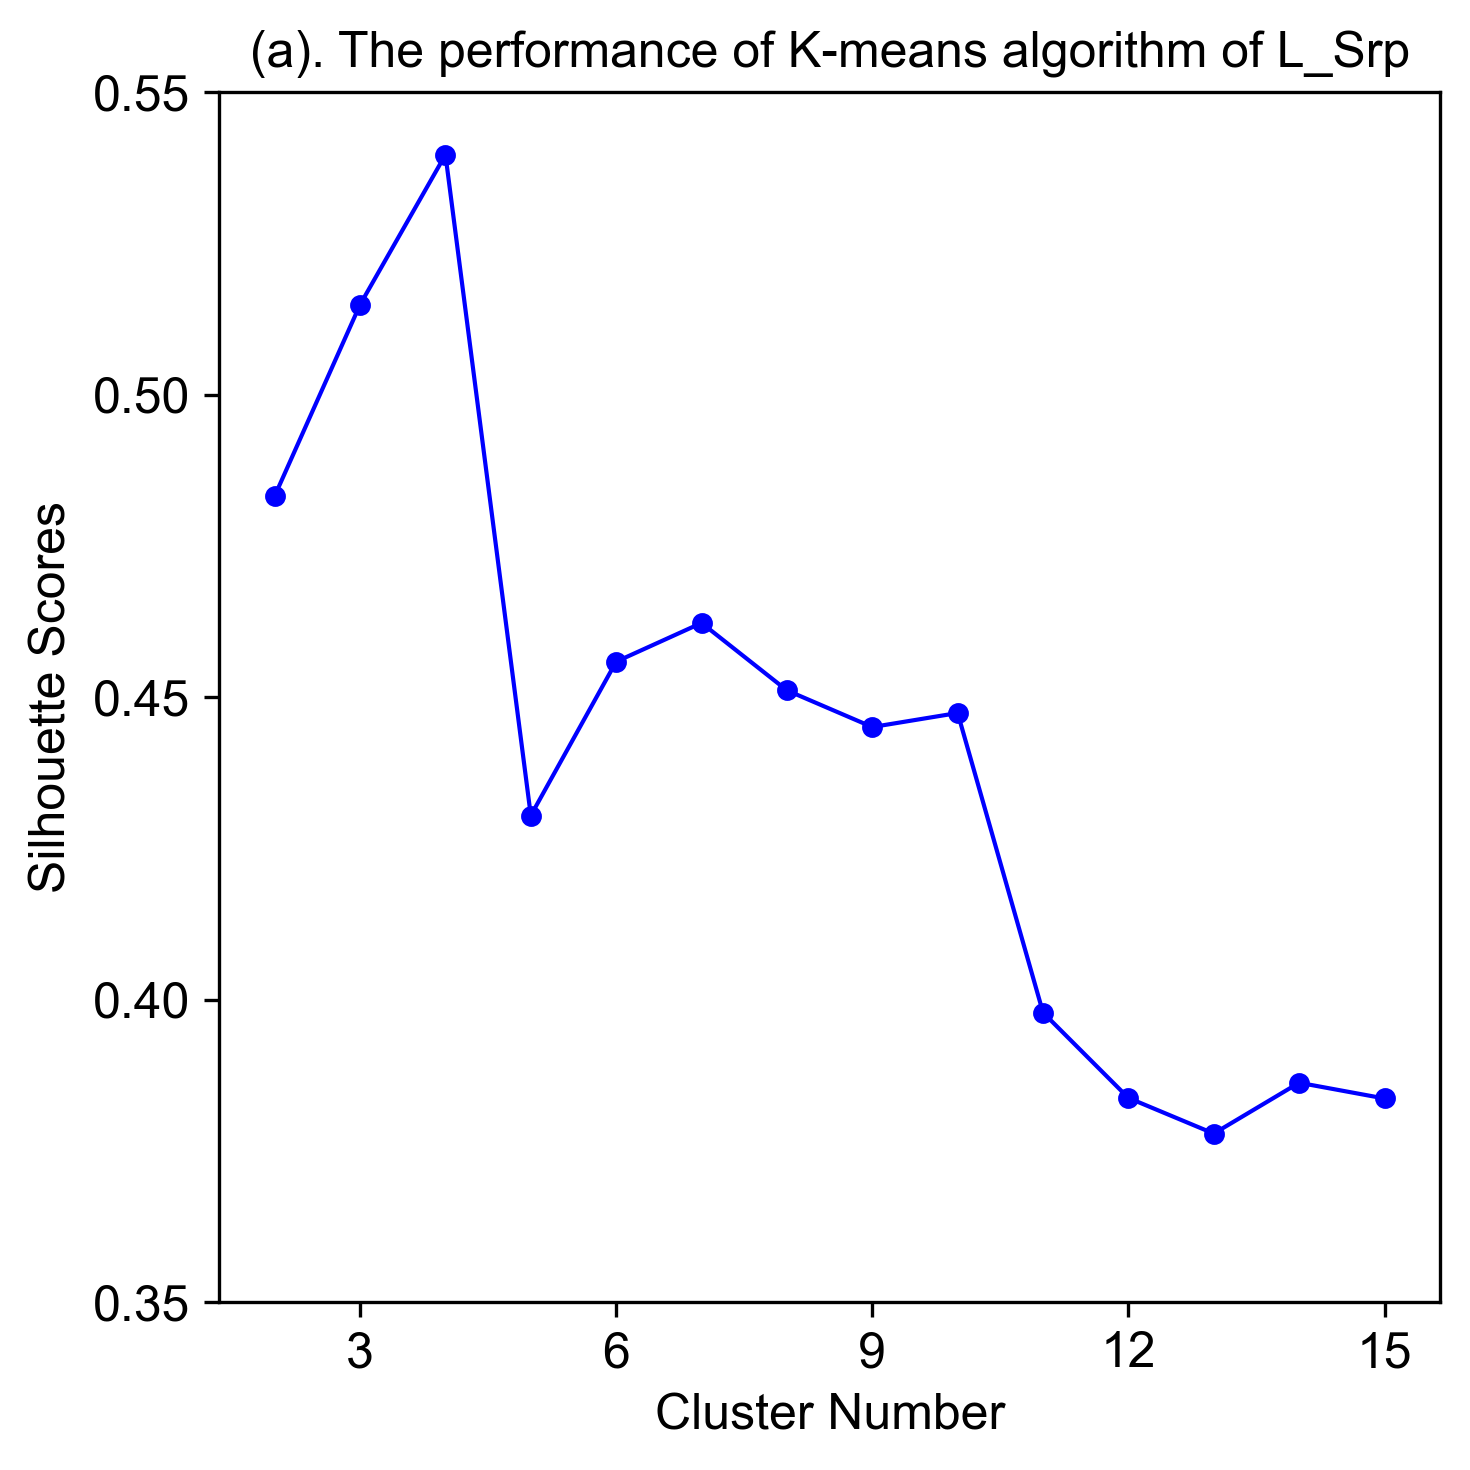

In [22]:
i = []
silhouette_scores = []

    
for k in range(2, 16):
    kmeans_model = KMeans(n_clusters=k, random_state=random_state, init='k-means++', n_init=10)
    pred = kmeans_model.fit_predict(X_L_Srp)
    i.append(k)
    silhouette_scores.append(silhouette_score(X_L_Srp, pred))
    

fig = plt.figure(figsize = (5, 5), dpi = 300, tight_layout = True)
plt.plot(i, silhouette_scores, 'bo-')
plt.xlabel('Cluster Number', fontsize = 12)
plt.xticks([3, 6, 9, 12, 15], fontsize = 12)
plt.ylim((0.35, 0.55))
plt.yticks([0.35, 0.40, 0.45, 0.50, 0.55], fontsize = 12)
plt.ylabel('Silhouette Scores', fontsize = 12)
plt.title('(a). The performance of K-means algorithm of L_Srp', fontsize = 12)
plt.savefig('./L_Srp_Silhouette Scores.png')

In [23]:
L_Srp_final = km_process(L_Srp_orig, 4)

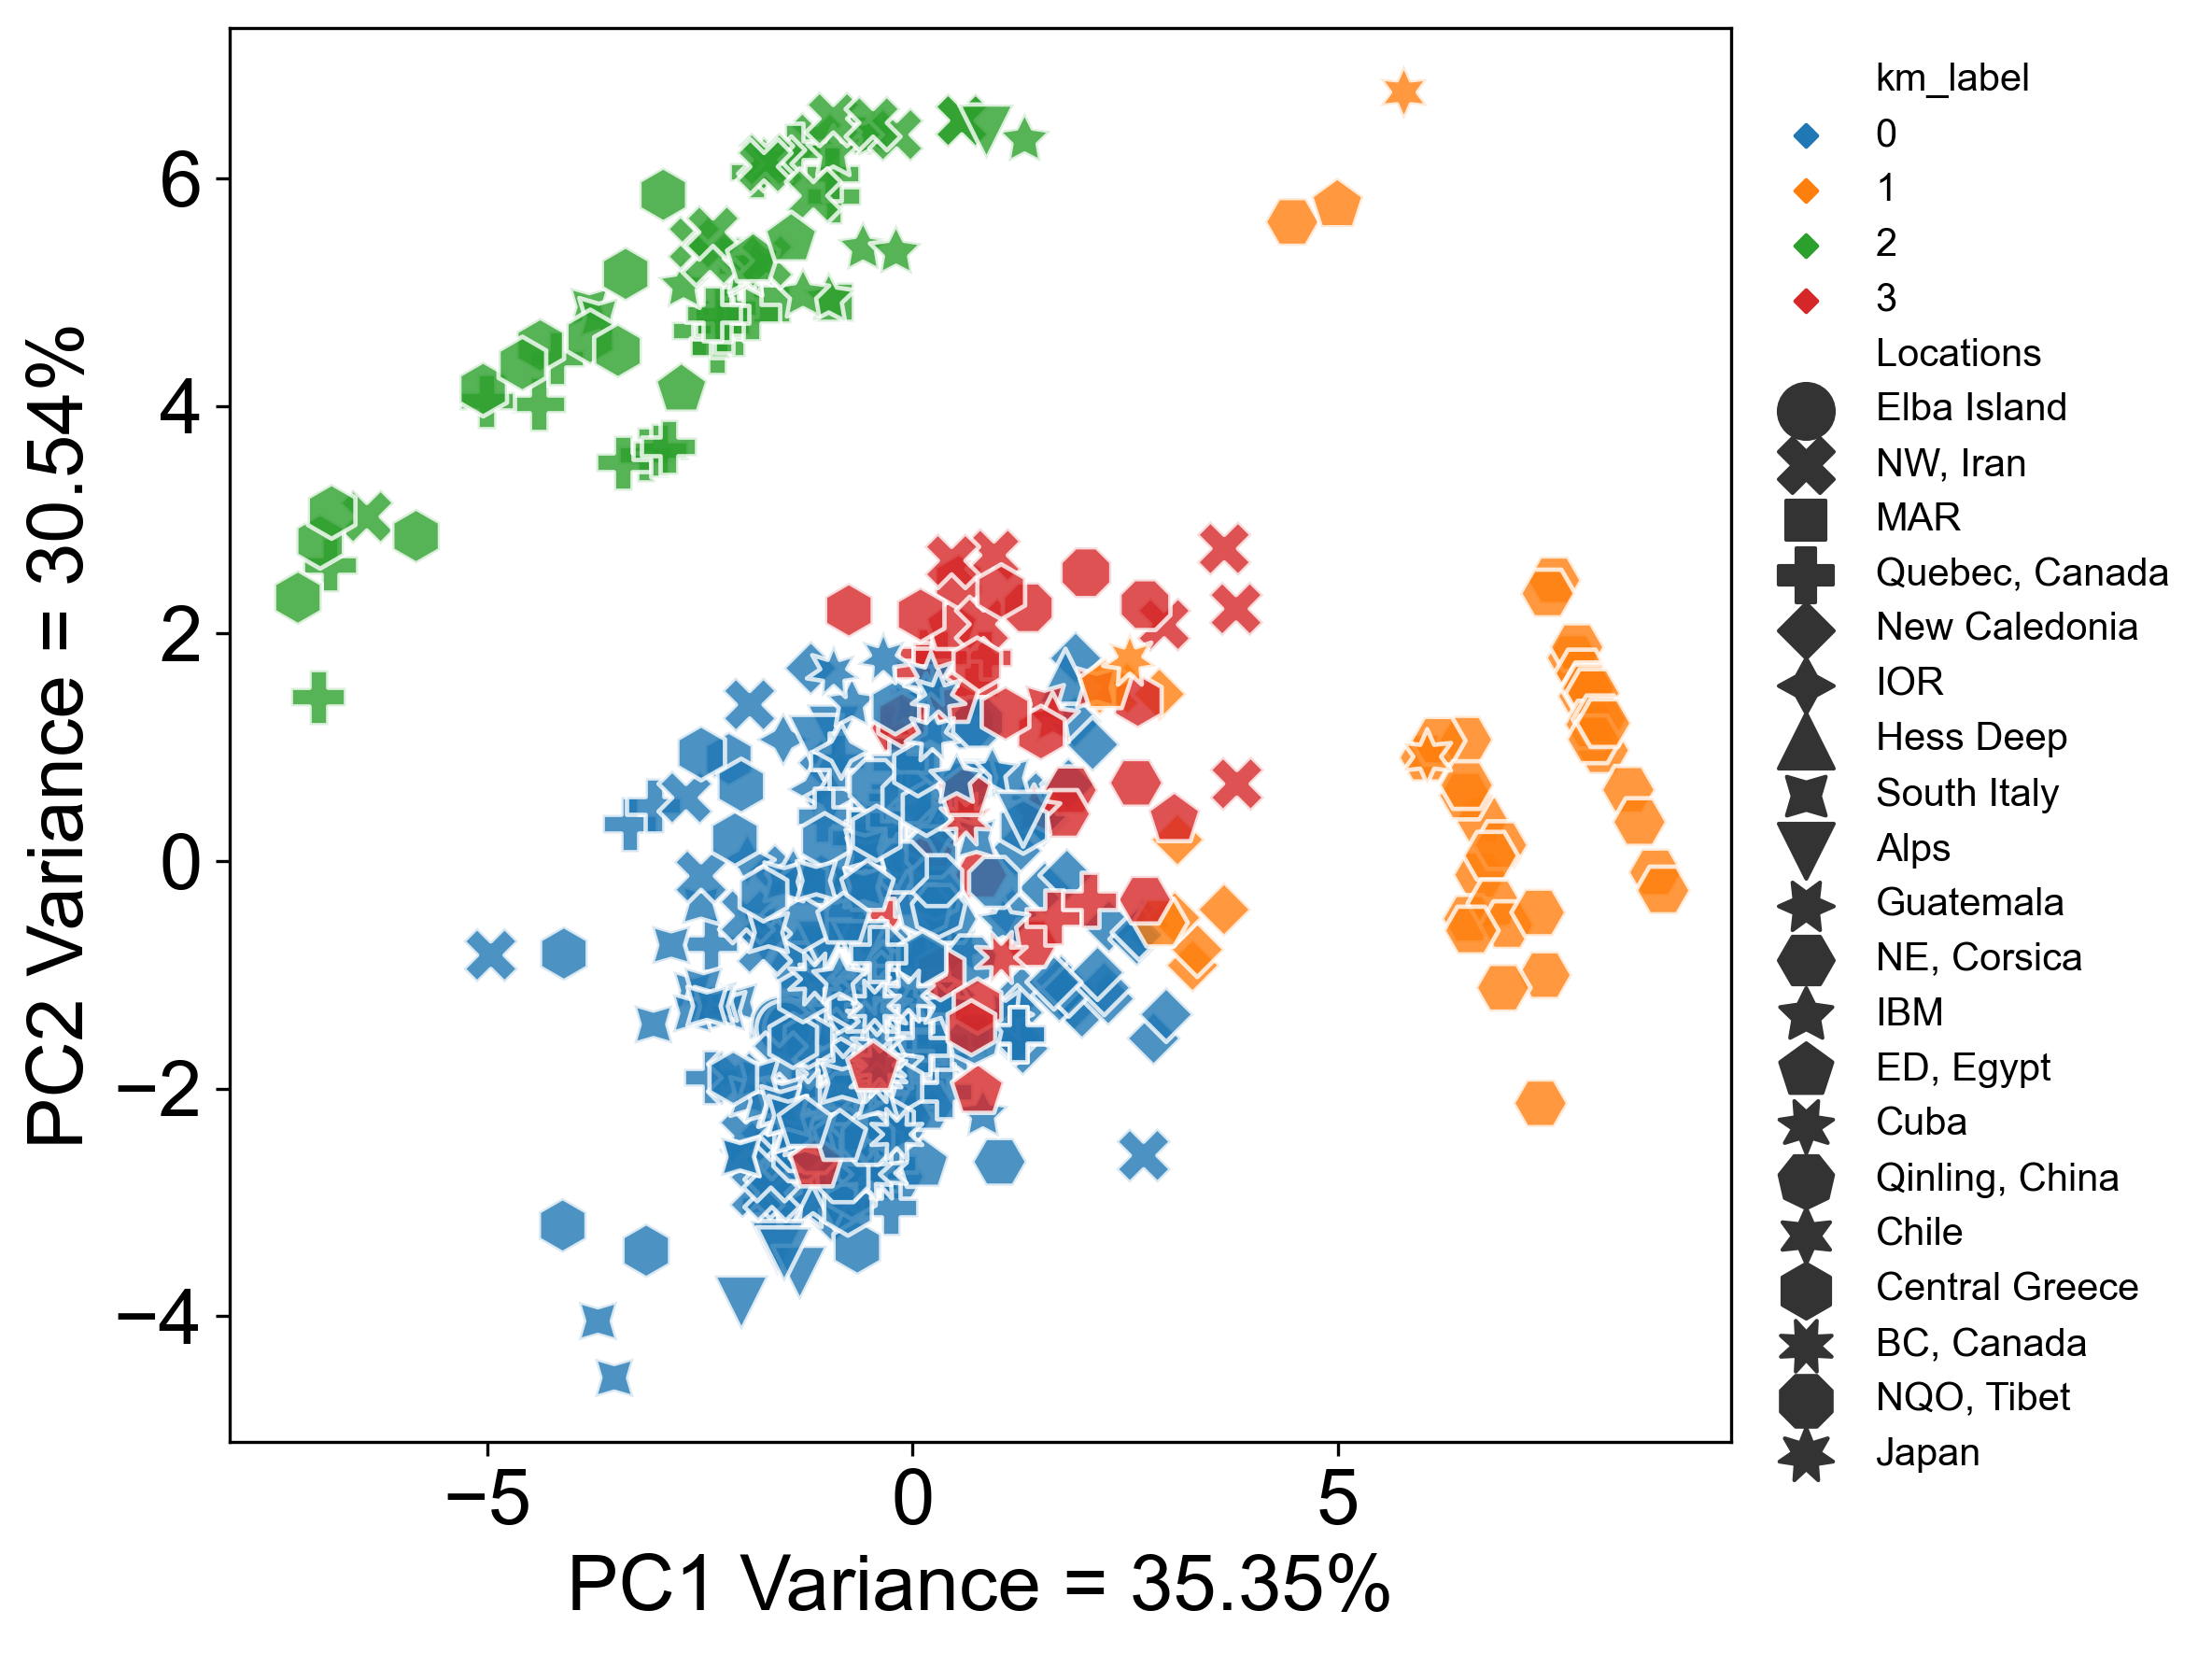

In [24]:
plot_scatter(L_Srp_final, 'PC1', 'PC2', 'km_label', 0.8, 'Locations', a, pca_L)
plt.savefig('./L_Srp_1.png')

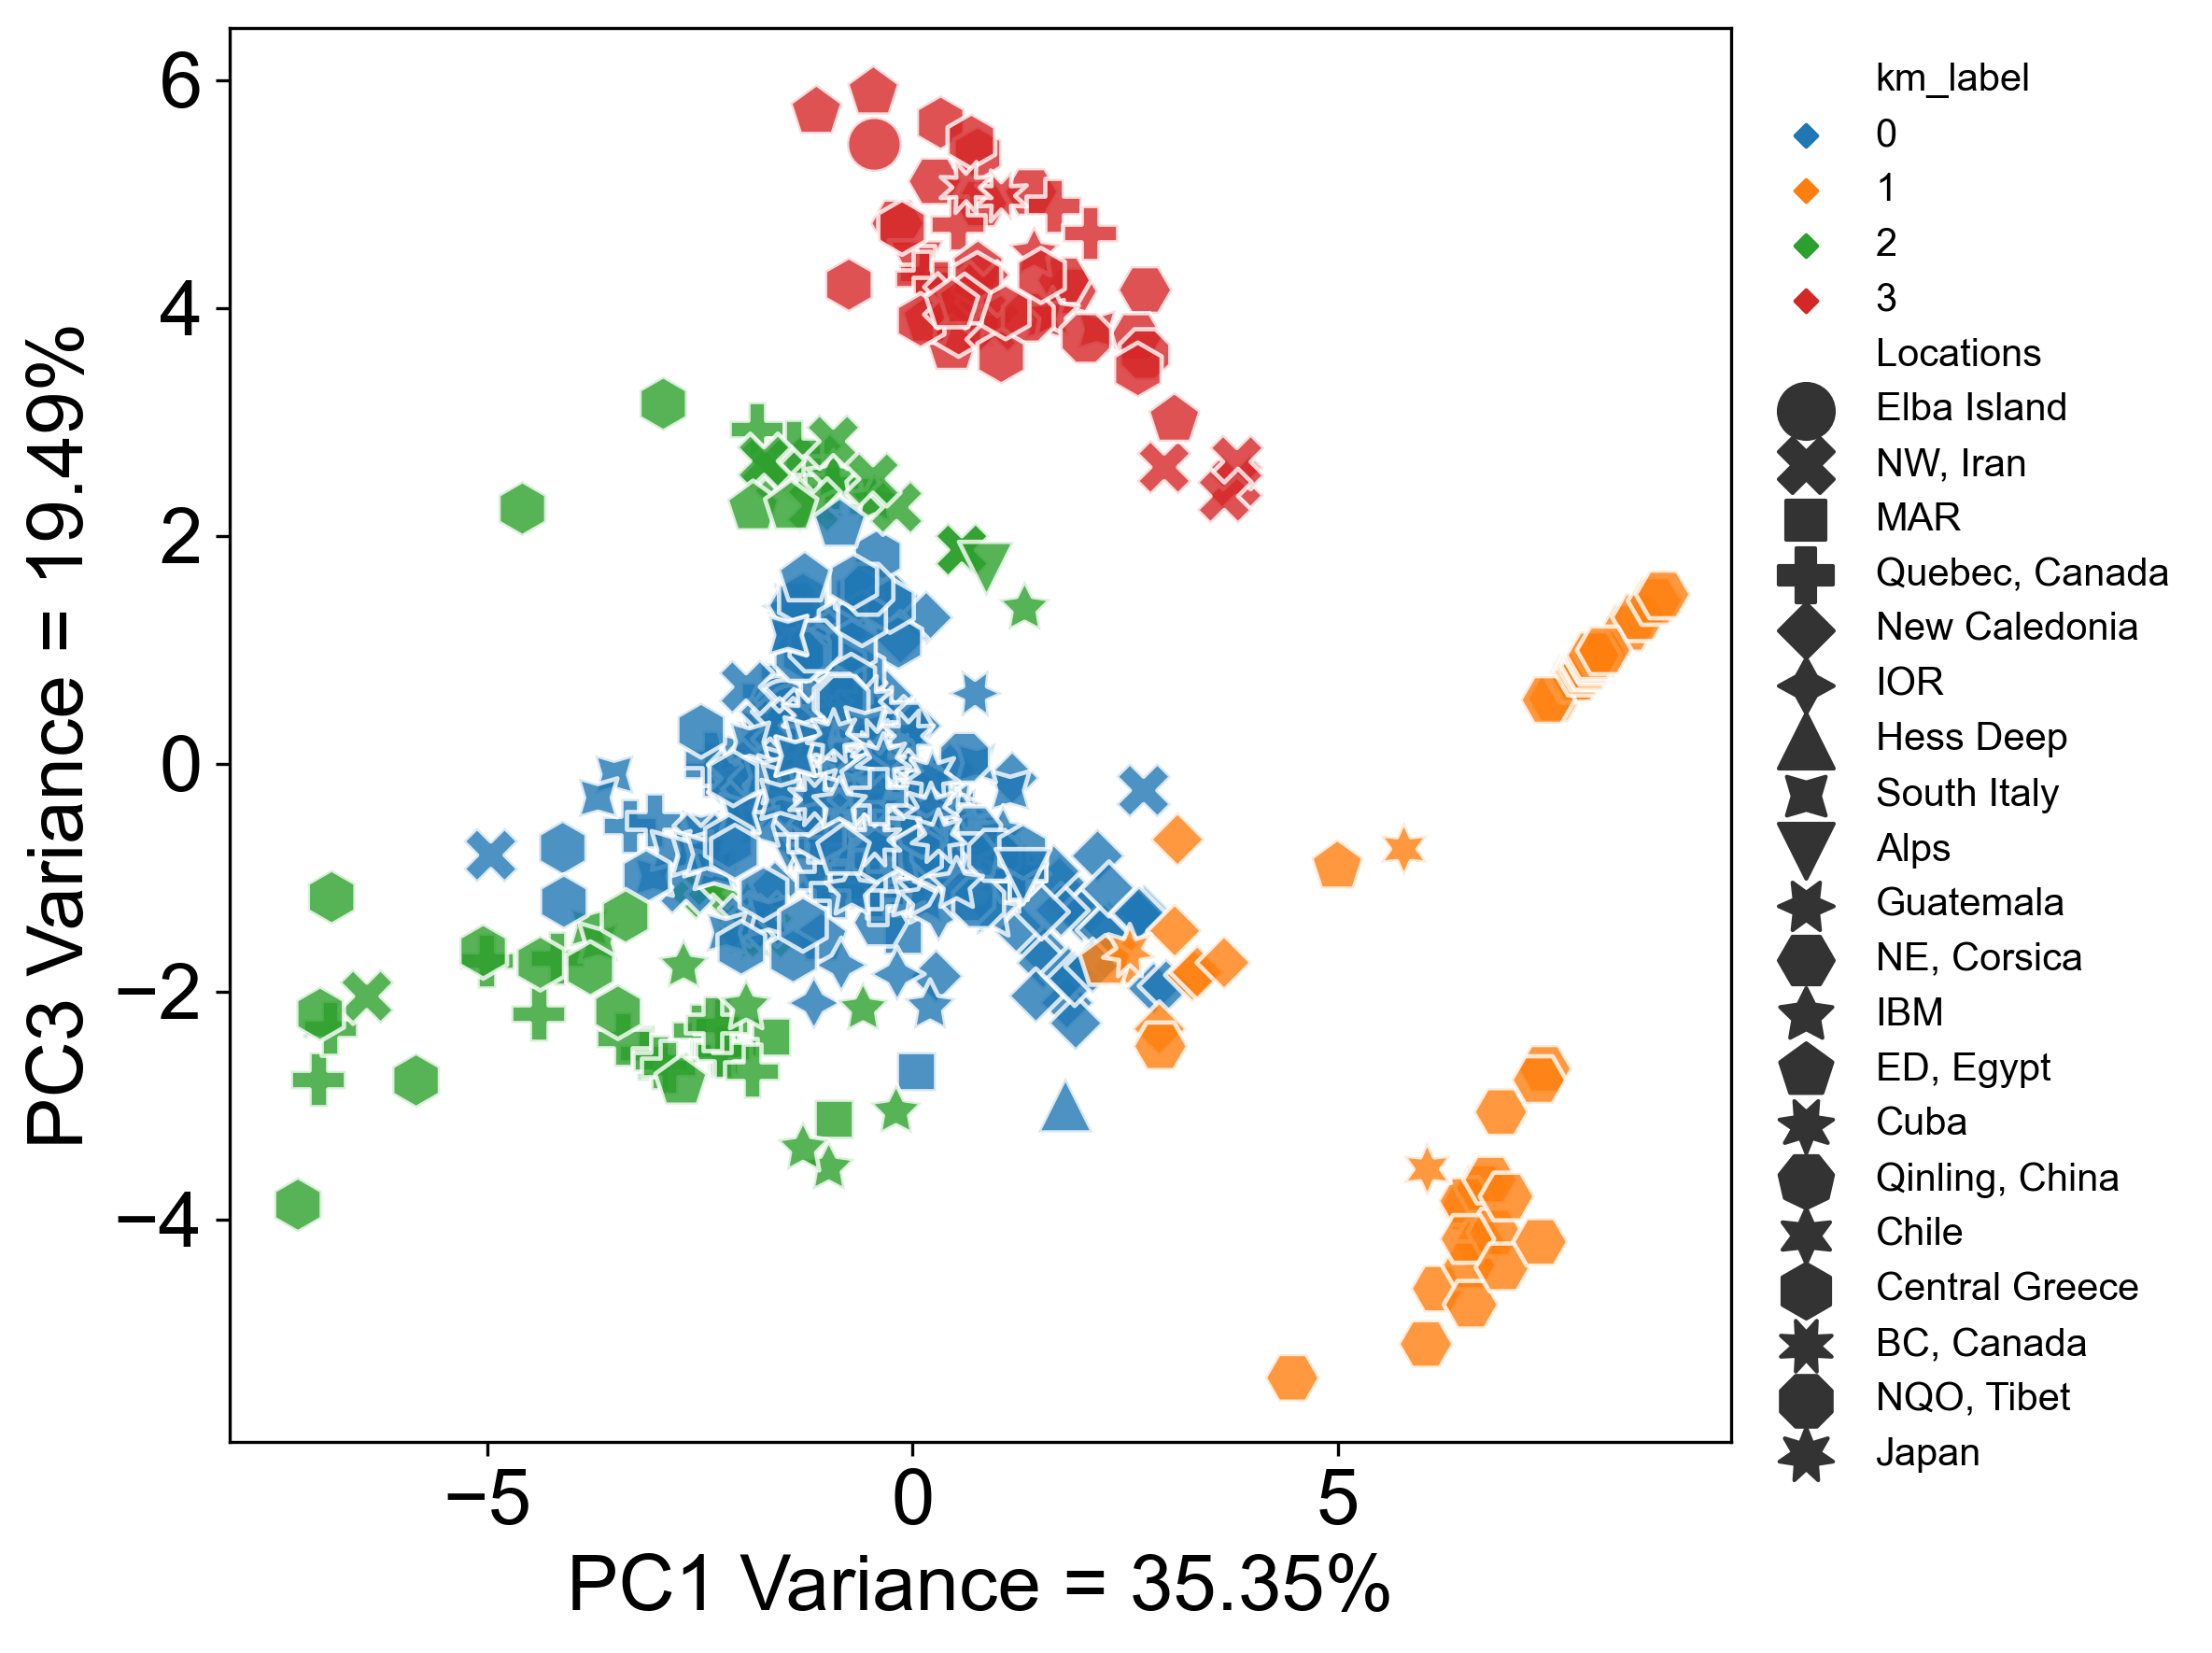

In [25]:
plot_scatter(L_Srp_final, 'PC1', 'PC3', 'km_label', 0.8, 'Locations', a, pca_L)
plt.savefig('./L_Srp_2.png')

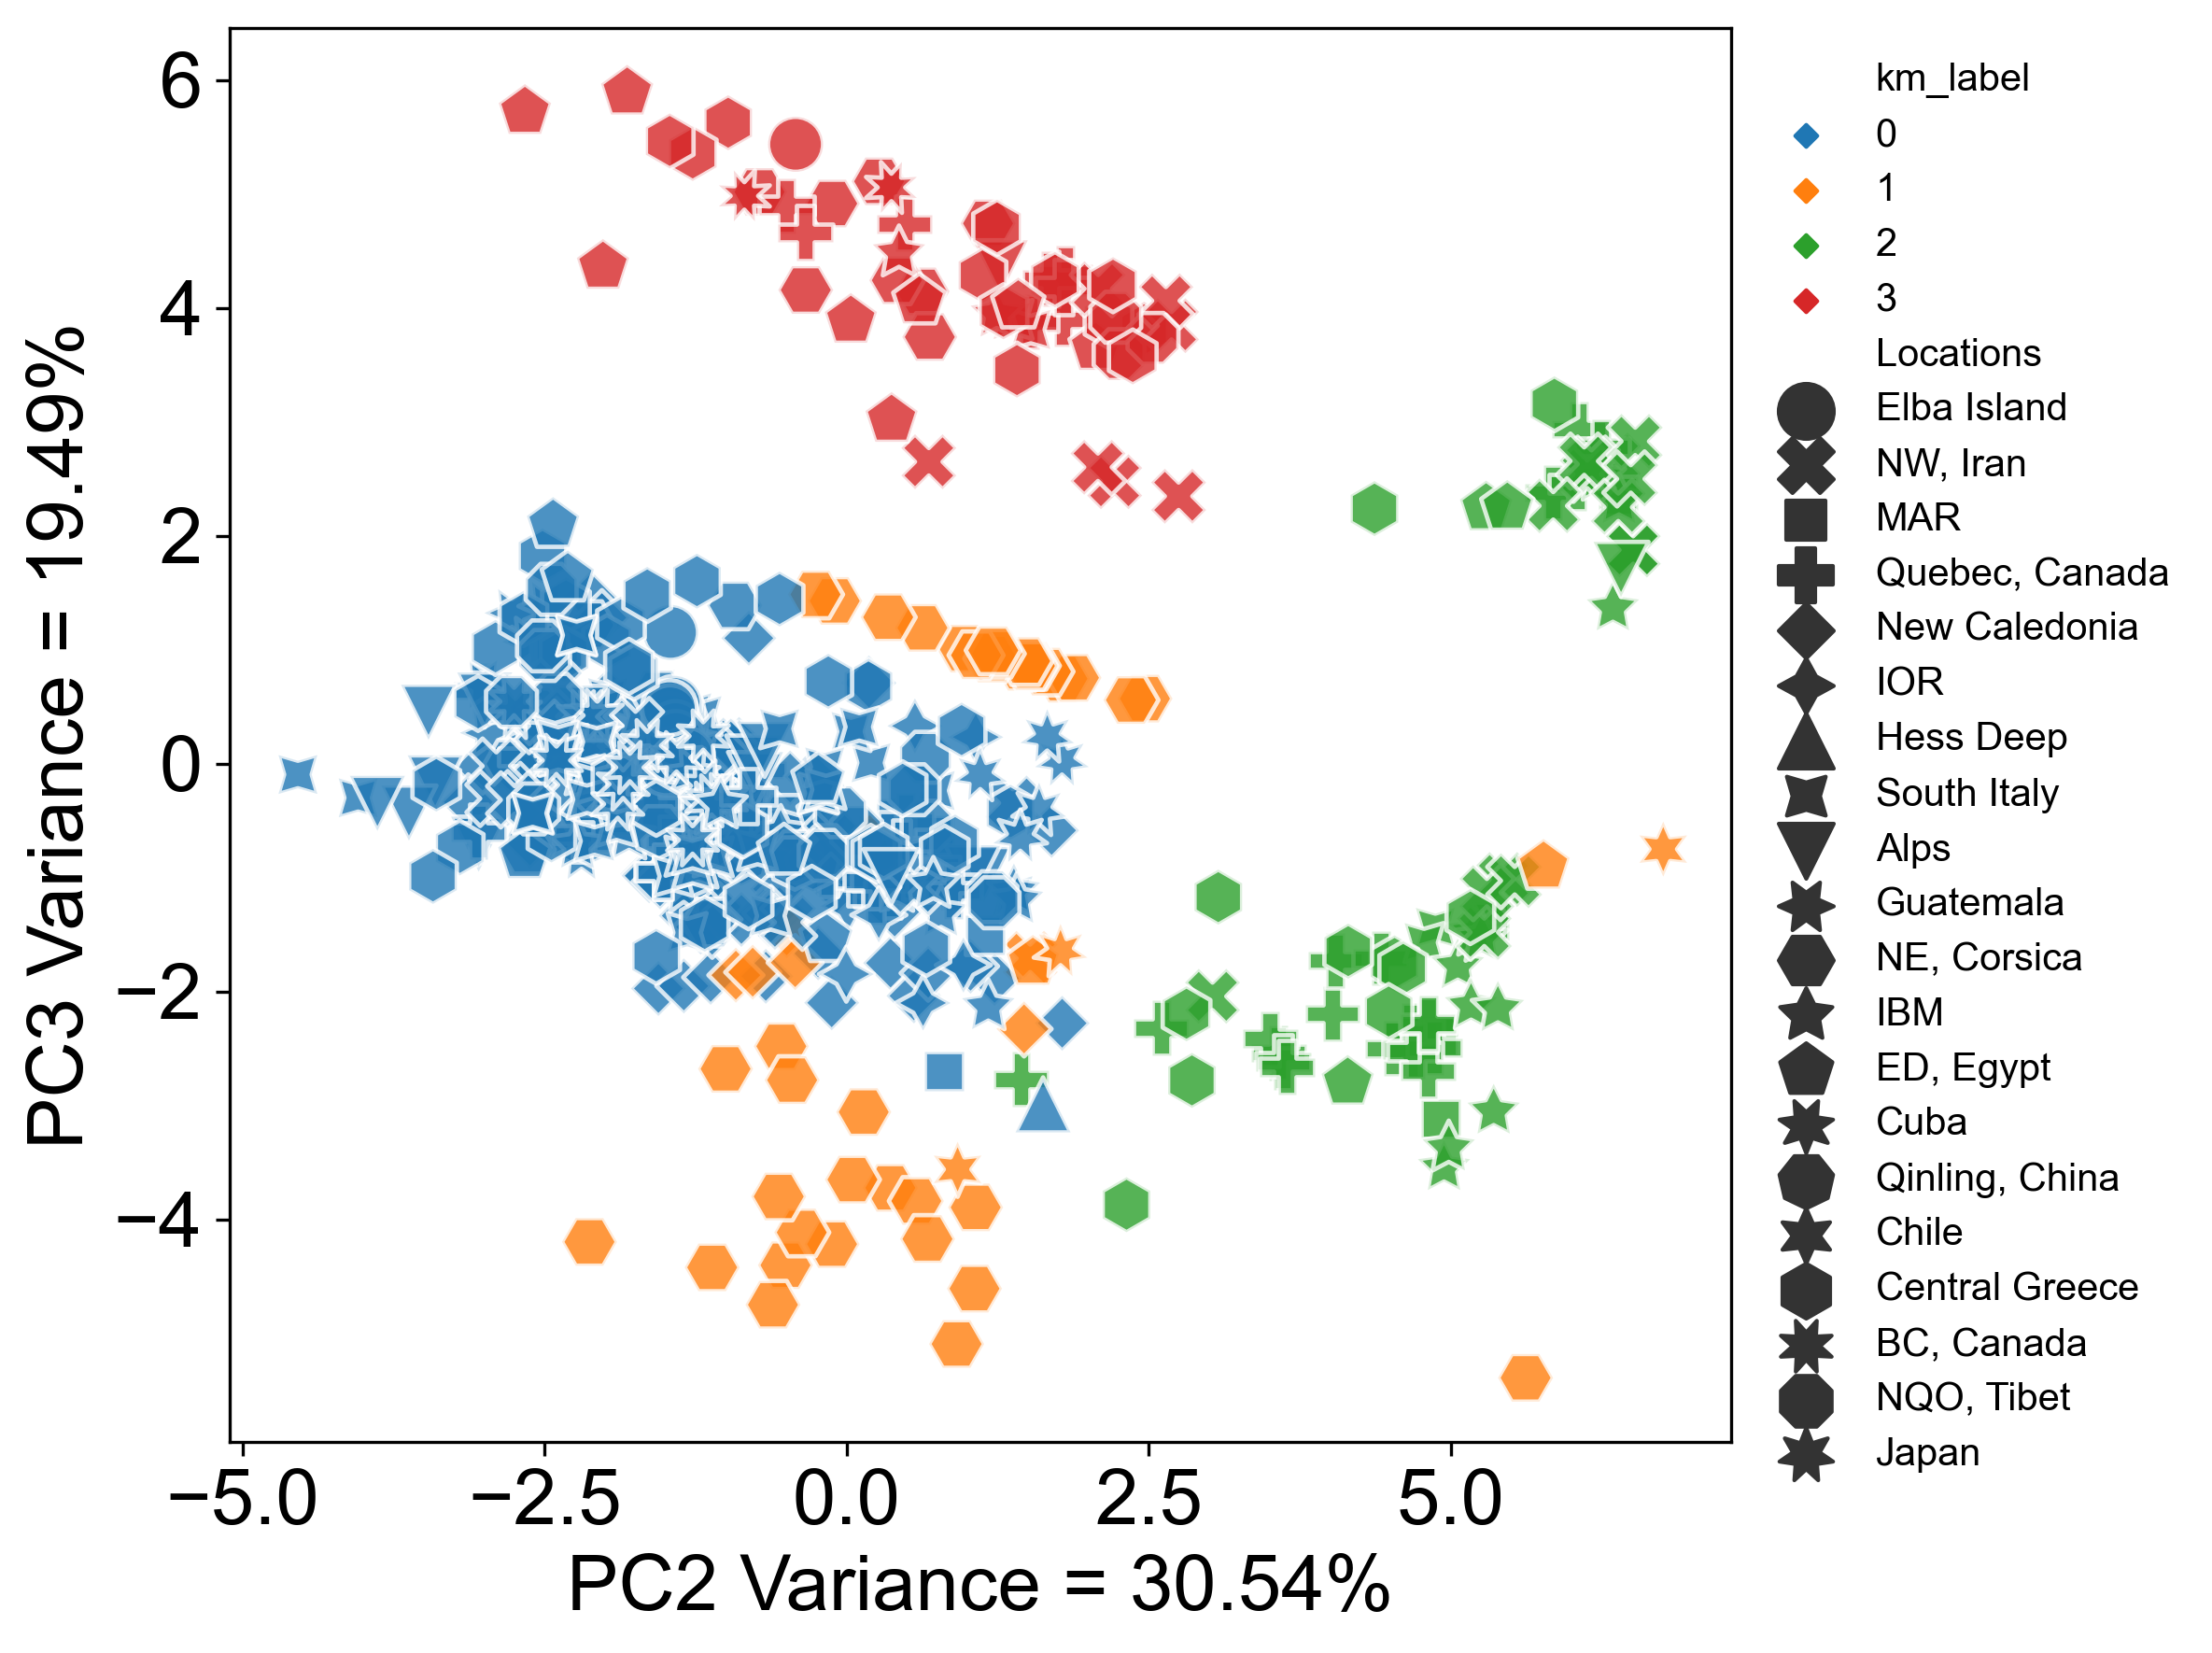

In [26]:
plot_scatter(L_Srp_final, 'PC2', 'PC3', 'km_label', 0.8, 'Locations', a, pca_L)
plt.savefig('./L_Srp_3.png')

In [27]:
# with pd.ExcelWriter('Ophiolite.xlsx', engine = 'openpyxl', mode = 'a') as writer:
# #     srp_final.to_excel(writer, sheet_name = 'Srp_km', float_format = '%.2f', index = False)
#     H_Srp_final.to_excel(writer, sheet_name = 'H_Srp_km', float_format = '%.2f', index = False)
#     L_Srp_final.to_excel(writer, sheet_name = 'L_Srp_km', float_format = '%.2f', index = False)